In [ ]:
# Download dataset
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("trafficlightdetect").project("traffic-light-ke5b5")
version = project.version(10)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8
loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to Traffic-light-10 in yolov8:: 100%|██████████| 2012/2012 [00:00<00:00, 2985.81it/s]


In [ ]:
# Add path to data.yaml to fix location issues
!echo "path: /content" >> /content/Traffic-light-10/data.yaml

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 925.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.7/871.7 kB 21.0 MB/s eta 0:00:00


# Weighted Dataloader

In [ ]:
from ultralytics import YOLO
from ultralytics.data.dataset import YOLODataset
import ultralytics.data.build as build
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
class YOLOWeightedDataset(YOLODataset):
    def __init__(self, *args, mode="train", **kwargs):
        """
        Initialize the WeightedDataset.

        Args:
            class_weights (list or numpy array): A list or array of weights corresponding to each class.
        """

        super(YOLOWeightedDataset, self).__init__(*args, **kwargs)

        self.train_mode = "train" in self.prefix

        # You can also specify weights manually instead
        self.count_instances()
        class_weights = np.sum(self.counts) / self.counts
        self.agg_func = np.mean

        self.class_weights = np.array(class_weights)
        self.weights = self.calculate_weights()
        self.probabilities = self.calculate_probabilities()

    def count_instances(self):
        """
        Count the number of instances per class

        Returns:
            dict: A dict containing the counts for each class.
        """
        self.counts = [0 for i in range(len(self.data["names"]))]
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)
            for id in cls:
                self.counts[id] += 1

        self.counts = np.array(self.counts)
        self.counts = np.where(self.counts == 0, 1, self.counts)

    def calculate_weights(self):
        """
        Calculate the aggregated weight for each label based on class weights.

        Returns:
            list: A list of aggregated weights corresponding to each label.
        """
        weights = []
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)

            # Give a default weight to background class
            if cls.size == 0:
              weights.append(1)
              continue

            # Take mean of weights
            # You can change this weight aggregation function to aggregate weights differently
            # weight = np.mean(self.class_weights[cls])
            # weight = np.max(self.class_weights[cls])
            weight = self.agg_func(self.class_weights[cls])
            weights.append(weight)
        return weights

    def calculate_probabilities(self):
        """
        Calculate and store the sampling probabilities based on the weights.

        Returns:
            list: A list of sampling probabilities corresponding to each label.
        """
        total_weight = sum(self.weights)
        probabilities = [w / total_weight for w in self.weights]
        return probabilities

    def __getitem__(self, index):
        """
        Return transformed label information based on the sampled index.
        """
        # Don't use for validation
        if not self.train_mode:
            return self.transforms(self.get_image_and_label(index))
        else:
            index = np.random.choice(len(self.labels), p=self.probabilities)
            return self.transforms(self.get_image_and_label(index))

In [ ]:
# Monkey patch method
build.YOLODataset = YOLOWeightedDataset

# Train without weighted dataloader

In [ ]:
# Revert to old class
build.YOLODataset = YOLODataset

In [ ]:
model = YOLO("yolov8n.pt")

In [ ]:
results = model.train(data="/content/Traffic-light-10/data.yaml", epochs=50)

Ultralytics YOLOv8.2.85 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/Traffic-light-10/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

train: Scanning /content/Traffic-light-10/train/labels.cache... 701 images, 12 backgrounds, 0 corrupt: 100%|██████████| 701/701 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /content/Traffic-light-10/valid/labels.cache... 199 images, 4 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 3, len(boxes) = 495. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.65G      2.143      5.668      1.073         53        640: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

                   all        199        495    0.00191      0.168     0.0113    0.00439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.25G       1.99      4.047     0.9975         56        640: 100%|██████████| 44/44 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        199        495      0.233     0.0835     0.0933     0.0436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.23G      1.989       3.31      1.017         67        640: 100%|██████████| 44/44 [00:14<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        199        495      0.615      0.149      0.241      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.25G      1.997      2.943      1.022         40        640: 100%|██████████| 44/44 [00:13<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


                   all        199        495      0.463      0.392      0.343      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.26G      1.886      2.507     0.9988         65        640: 100%|██████████| 44/44 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]

                   all        199        495      0.444      0.389      0.349      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.25G      1.849      2.243      1.043         51        640: 100%|██████████| 44/44 [00:14<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


                   all        199        495      0.525      0.445      0.373      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.23G      1.898      2.043      1.016         48        640: 100%|██████████| 44/44 [00:14<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        199        495      0.586      0.422      0.443      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.25G      1.756        1.7     0.9717         71        640: 100%|██████████| 44/44 [00:14<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        199        495      0.608      0.448      0.495      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.23G      1.874      1.689      1.007         67        640: 100%|██████████| 44/44 [00:21<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

                   all        199        495      0.679      0.407      0.474      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.25G       1.82      1.545     0.9911         47        640: 100%|██████████| 44/44 [00:17<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        199        495      0.673      0.468        0.5       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.25G      1.737      1.417     0.9996         48        640: 100%|██████████| 44/44 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        199        495      0.638      0.495      0.529      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.25G      1.745      1.323     0.9901         63        640: 100%|██████████| 44/44 [00:17<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        199        495      0.627      0.512       0.51      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.23G      1.786      1.446     0.9631         43        640: 100%|██████████| 44/44 [00:16<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        199        495      0.629      0.507      0.506      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.25G      1.676      1.269     0.9514         63        640: 100%|██████████| 44/44 [00:17<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        199        495      0.726      0.496      0.561      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.25G      1.694       1.24     0.9497         41        640: 100%|██████████| 44/44 [00:15<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        199        495      0.725      0.514      0.565      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.23G      1.674      1.267     0.9687         51        640: 100%|██████████| 44/44 [00:16<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        199        495       0.68      0.511      0.537      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.25G       1.68      1.206     0.9725         52        640: 100%|██████████| 44/44 [00:16<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        199        495      0.735      0.556      0.566      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.23G       1.64      1.228     0.9402         62        640: 100%|██████████| 44/44 [00:17<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        199        495      0.648      0.487      0.515      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.25G      1.611      1.121     0.9642         53        640: 100%|██████████| 44/44 [00:17<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        199        495       0.69      0.526       0.55      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.25G      1.586      1.066     0.9475         83        640: 100%|██████████| 44/44 [00:17<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        199        495      0.702       0.54      0.568      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.23G      1.577      1.056     0.9345         54        640: 100%|██████████| 44/44 [00:16<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        199        495      0.689      0.545      0.573      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.25G       1.61      1.059     0.9318         48        640: 100%|██████████| 44/44 [00:17<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        199        495      0.688      0.521      0.588      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.25G      1.527      1.008     0.9366         60        640: 100%|██████████| 44/44 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        199        495      0.734      0.534      0.586      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.26G      1.567      1.026     0.9305         70        640: 100%|██████████| 44/44 [00:16<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        199        495       0.73      0.501      0.542      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.23G      1.514     0.9527     0.9212         72        640: 100%|██████████| 44/44 [00:16<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        199        495      0.674       0.55      0.579      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.23G      1.513     0.9604     0.9249         42        640: 100%|██████████| 44/44 [00:15<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]

                   all        199        495      0.728      0.514      0.549      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.25G       1.52      0.971      0.931         53        640: 100%|██████████| 44/44 [00:15<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]

                   all        199        495      0.727      0.545      0.609      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.23G      1.533     0.9584     0.9216         60        640: 100%|██████████| 44/44 [00:14<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


                   all        199        495      0.741      0.578      0.609      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.23G      1.496     0.9133     0.9209         34        640: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        199        495      0.748      0.562      0.609      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.23G      1.503     0.9541     0.9259         46        640: 100%|██████████| 44/44 [00:14<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


                   all        199        495      0.757      0.602      0.619      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.25G      1.537     0.9527     0.9068         53        640: 100%|██████████| 44/44 [00:14<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        199        495      0.726      0.577      0.604      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.25G      1.514     0.9259     0.9075         50        640: 100%|██████████| 44/44 [00:14<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]

                   all        199        495       0.79      0.561      0.619      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.26G      1.416     0.8567     0.9047         62        640: 100%|██████████| 44/44 [00:14<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]

                   all        199        495      0.766      0.573      0.615      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.25G      1.467     0.8873     0.8941         41        640: 100%|██████████| 44/44 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        199        495      0.704      0.576      0.598      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.25G      1.379     0.8361     0.8987         62        640: 100%|██████████| 44/44 [00:15<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        199        495      0.738      0.618      0.635      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.25G      1.369     0.8451     0.9021         63        640: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]

                   all        199        495      0.772      0.576      0.637      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.23G      1.437     0.8702     0.8876         60        640: 100%|██████████| 44/44 [00:15<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        199        495       0.79      0.572      0.639      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.25G      1.373      0.812     0.8897         64        640: 100%|██████████| 44/44 [00:14<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]

                   all        199        495      0.742      0.609      0.643      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.25G      1.373     0.8045     0.8843         59        640: 100%|██████████| 44/44 [00:14<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

                   all        199        495      0.815      0.558      0.643      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.25G      1.375     0.8397     0.8925         48        640: 100%|██████████| 44/44 [00:14<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]

                   all        199        495      0.799      0.611      0.656       0.35


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       2.3G      1.353     0.8329     0.8927         30        640: 100%|██████████| 44/44 [00:18<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]

                   all        199        495      0.812      0.598       0.66      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.21G      1.343     0.8206      0.872         29        640: 100%|██████████| 44/44 [00:14<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        199        495      0.781       0.54      0.613       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.21G      1.398     0.8443       0.89         32        640: 100%|██████████| 44/44 [00:14<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]

                   all        199        495      0.737      0.615      0.633      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.21G       1.32     0.7966     0.8898         36        640: 100%|██████████| 44/44 [00:13<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        199        495      0.841       0.58      0.649      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.23G      1.321     0.7742     0.8855         26        640: 100%|██████████| 44/44 [00:13<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


                   all        199        495      0.813       0.59       0.64      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.23G      1.302     0.7791     0.8687         30        640: 100%|██████████| 44/44 [00:13<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        199        495      0.824      0.575      0.646      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.23G      1.312      0.764     0.8717         26        640: 100%|██████████| 44/44 [00:14<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]

                   all        199        495       0.81      0.599      0.655      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.21G      1.295     0.7721     0.8688         33        640: 100%|██████████| 44/44 [00:15<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        199        495        0.8      0.606      0.657      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.23G      1.289     0.7574     0.8627         26        640: 100%|██████████| 44/44 [00:14<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]

                   all        199        495      0.788      0.616      0.656      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.23G      1.255     0.7586     0.8572         24        640: 100%|██████████| 44/44 [00:15<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        199        495      0.764      0.603      0.647      0.356



50 epochs completed in 0.281 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.2.85 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


                   all        199        495      0.764      0.604      0.647      0.357
           Green Light        123        260      0.822      0.693      0.755      0.397
             Left turn         36         65       0.91      0.619      0.688      0.387
             Red Light         61        135      0.728      0.595      0.589      0.301
          Yellow Light         15         35      0.598       0.51      0.556      0.343
Speed: 0.6ms preprocess, 2.9ms inference, 0.0ms loss, 8.5ms postprocess per image
Results saved to runs/detect/train5


In [ ]:
# Verify the type of dataset used
model.trainer.train_loader.dataset

In [ ]:
img = cv2.imread("runs/detect/train/train_batch1.jpg")[...,::-1]

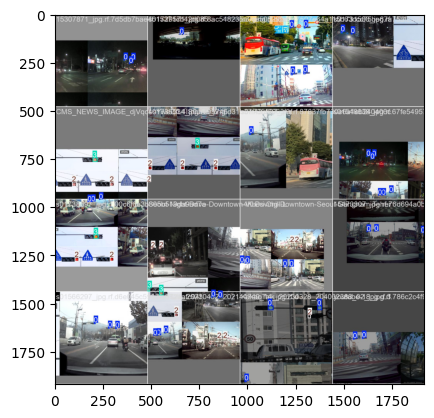

In [ ]:
# Training plots will be unbalanced
plt.imshow(img)

# Train with weighted dataloader

In [ ]:
# Monkey patch method to use weighted dataloader
# This might not work with multi-GPU training.
# Go to the end of the notebook for multi-GPU workaround.
build.YOLODataset = YOLOWeightedDataset

In [ ]:
model = YOLO("yolov8n.pt")

In [ ]:
results = model.train(data="/content/Traffic-light-10/data.yaml", epochs=50)

Ultralytics YOLOv8.2.85 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/Traffic-light-10/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

train: Scanning /content/Traffic-light-10/train/labels.cache... 701 images, 12 backgrounds, 0 corrupt: 100%|██████████| 701/701 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /content/Traffic-light-10/valid/labels.cache... 199 images, 4 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 3, len(boxes) = 495. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train6
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.34G      1.863      4.856      1.044         54        640: 100%|██████████| 44/44 [00:17<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


                   all        199        495   0.000727      0.118     0.0165       0.01

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.31G      1.808       3.19     0.9874         69        640: 100%|██████████| 44/44 [00:16<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]


                   all        199        495       0.82      0.031      0.222     0.0917

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.23G      1.865      3.009      1.004         64        640: 100%|██████████| 44/44 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]


                   all        199        495        0.6      0.344      0.335      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.25G      1.782      2.438      1.023         51        640: 100%|██████████| 44/44 [00:16<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        199        495      0.548      0.403      0.384      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.25G       1.74      2.161      1.013         63        640: 100%|██████████| 44/44 [00:15<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]

                   all        199        495      0.539      0.409      0.414      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.24G      1.726      1.951      1.017         56        640: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        199        495       0.59       0.46      0.459      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.24G      1.674      1.724     0.9928         42        640: 100%|██████████| 44/44 [00:14<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


                   all        199        495      0.644      0.443      0.481      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.25G      1.679      1.563     0.9816         82        640: 100%|██████████| 44/44 [00:14<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

                   all        199        495      0.681      0.448      0.499      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.22G      1.617      1.452     0.9687         41        640: 100%|██████████| 44/44 [00:13<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]

                   all        199        495      0.632      0.469      0.482      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.25G      1.612      1.394     0.9688         50        640: 100%|██████████| 44/44 [00:13<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        199        495      0.659      0.439      0.531      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.23G      1.591      1.316     0.9848         40        640: 100%|██████████| 44/44 [00:14<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        199        495      0.674      0.472      0.519      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.23G      1.535      1.232     0.9664         53        640: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

                   all        199        495      0.736      0.492      0.551      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.25G      1.557      1.196     0.9618         33        640: 100%|██████████| 44/44 [00:15<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        199        495      0.698      0.471      0.525      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.25G      1.476       1.06     0.9415         56        640: 100%|██████████| 44/44 [00:15<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        199        495      0.704       0.51      0.545      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.25G      1.491      1.051     0.9476         45        640: 100%|██████████| 44/44 [00:16<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        199        495      0.722      0.522      0.544      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.23G      1.548      1.149     0.9334         72        640: 100%|██████████| 44/44 [00:16<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        199        495      0.684      0.516      0.567      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.24G      1.575      1.087     0.9608         47        640: 100%|██████████| 44/44 [00:16<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

                   all        199        495      0.777      0.466      0.535      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.24G      1.498      1.015     0.9283         57        640: 100%|██████████| 44/44 [00:16<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        199        495      0.789      0.518      0.577      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.25G      1.417     0.9538     0.9235         44        640: 100%|██████████| 44/44 [00:15<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        199        495      0.673      0.526      0.537      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.23G      1.458      1.004     0.9334         80        640: 100%|██████████| 44/44 [00:16<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        199        495      0.777      0.561      0.621      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.22G      1.442     0.9583     0.9422         53        640: 100%|██████████| 44/44 [00:15<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

                   all        199        495      0.716      0.549      0.581      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.25G      1.482     0.9962     0.9464         46        640: 100%|██████████| 44/44 [00:15<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        199        495      0.728      0.499      0.577      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.22G      1.437     0.9283     0.9313         65        640: 100%|██████████| 44/44 [00:16<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        199        495      0.808      0.546      0.616      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.23G      1.393     0.9196     0.9178         67        640: 100%|██████████| 44/44 [00:16<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        199        495      0.702      0.523      0.569      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.23G      1.392     0.9003      0.894         71        640: 100%|██████████| 44/44 [00:16<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        199        495      0.735      0.572      0.623      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.23G      1.385      0.918     0.9125         48        640: 100%|██████████| 44/44 [00:16<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]

                   all        199        495       0.76      0.519      0.576      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.25G      1.409     0.8674     0.9096         66        640: 100%|██████████| 44/44 [00:14<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        199        495      0.709      0.589      0.621      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.23G      1.402     0.8711     0.9095         75        640: 100%|██████████| 44/44 [00:14<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        199        495      0.764      0.606      0.652      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.25G      1.327     0.8232     0.8859         39        640: 100%|██████████| 44/44 [00:13<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


                   all        199        495      0.815      0.592      0.653      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.23G      1.293     0.8056      0.897         65        640: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]

                   all        199        495       0.75      0.584       0.64      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.24G      1.276     0.7708     0.8901         71        640: 100%|██████████| 44/44 [00:13<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


                   all        199        495      0.732       0.58      0.624       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.23G      1.298     0.8328     0.8874         55        640: 100%|██████████| 44/44 [00:13<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        199        495      0.739      0.567      0.631      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.23G      1.259     0.7862     0.8992         64        640: 100%|██████████| 44/44 [00:14<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        199        495       0.74      0.582      0.625      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.23G      1.297     0.7878     0.8896         63        640: 100%|██████████| 44/44 [00:16<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        199        495      0.773      0.592       0.65       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.23G      1.266     0.7656     0.8814         50        640: 100%|██████████| 44/44 [00:19<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        199        495      0.813      0.561      0.642      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.25G      1.242     0.7421     0.8798         76        640: 100%|██████████| 44/44 [00:15<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        199        495      0.829       0.58       0.65      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.22G      1.232     0.7542     0.8774         76        640: 100%|██████████| 44/44 [00:17<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        199        495      0.736      0.612      0.653      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.25G      1.256     0.7664     0.8744         61        640: 100%|██████████| 44/44 [00:16<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        199        495      0.753      0.603       0.65      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.23G      1.213     0.7184     0.8946         54        640: 100%|██████████| 44/44 [00:17<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        199        495      0.856      0.567      0.649      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.22G      1.228     0.7438     0.8695         64        640: 100%|██████████| 44/44 [00:16<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        199        495      0.749      0.606      0.651      0.341


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.26G      1.186     0.7287     0.8782         31        640: 100%|██████████| 44/44 [00:17<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        199        495      0.762       0.59      0.646      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.22G      1.172     0.7283     0.8644         33        640: 100%|██████████| 44/44 [00:16<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        199        495      0.746      0.612      0.639      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       2.2G      1.137     0.6623     0.8666         35        640: 100%|██████████| 44/44 [00:15<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        199        495      0.754       0.59      0.633      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       2.2G      1.219     0.7127     0.8573         33        640: 100%|██████████| 44/44 [00:15<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        199        495      0.792      0.573      0.627      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       2.2G      1.134      0.684     0.8524         27        640: 100%|██████████| 44/44 [00:15<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        199        495      0.822      0.601      0.659      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       2.2G      1.069     0.6538     0.8581         34        640: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]

                   all        199        495      0.816      0.579      0.647      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       2.2G      1.124     0.6369     0.8463         33        640: 100%|██████████| 44/44 [00:13<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        199        495      0.813      0.567      0.642      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       2.2G      1.116     0.6584     0.8555         31        640: 100%|██████████| 44/44 [00:12<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


                   all        199        495      0.821      0.576      0.652      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       2.2G      1.166     0.6808     0.8627         42        640: 100%|██████████| 44/44 [00:12<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


                   all        199        495      0.817      0.592      0.659      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       2.2G      1.055     0.6455     0.8616         34        640: 100%|██████████| 44/44 [00:13<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


                   all        199        495      0.831      0.599      0.673      0.351

50 epochs completed in 0.271 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 6.2MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics YOLOv8.2.85 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


                   all        199        495      0.831      0.601      0.673      0.351
           Green Light        123        260      0.895      0.658      0.754      0.383
             Left turn         36         65      0.906      0.596      0.692      0.351
             Red Light         61        135      0.811      0.578      0.623       0.32
          Yellow Light         15         35      0.712      0.571      0.622      0.351
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 6.8ms postprocess per image
Results saved to runs/detect/train6


In [ ]:
# Verify the type of dataset used. It should say
# YOLOWeightedDataset
model.trainer.train_loader.dataset

In [ ]:
img = cv2.imread("runs/detect/train1/train_batch0.jpg")[...,::-1]

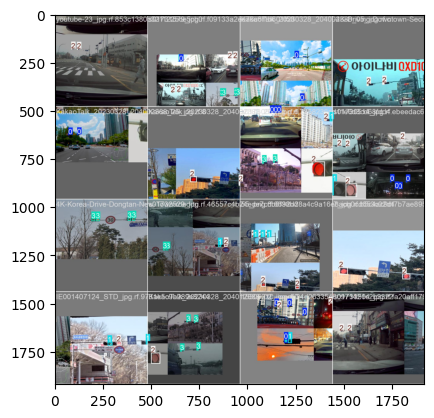

In [ ]:
# Training plots will be balanced
plt.imshow(img)

# Check class balance

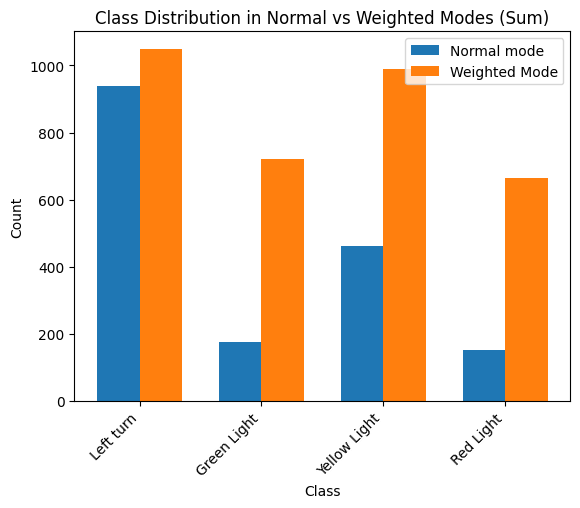

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def verify_class_balance(dataset, num_samples=1000):
    """
    Verifies whether the __getitem__ method in the YOLOWeightedDataset class returns a balanced class output.

    Args:
        dataset: An instance of YOLOWeightedDataset.
        num_samples: Number of samples to draw from the dataset.

    Returns:
        class_counts: A dictionary containing the class counts.
    """
    all_labels = []
    num_samples = min(len(dataset.labels), num_samples)

    if dataset.train_mode:
        choices = np.random.choice(len(dataset.labels), size=num_samples, p=dataset.probabilities)
    else:
        choices = np.random.choice(len(dataset.labels), size=num_samples, replace=False)

    for i in choices:
        label = dataset.labels[i]["cls"]
        all_labels.extend(label.reshape(-1).astype(int))

    class_counts = Counter(all_labels)
    return class_counts

def plot_class_balance(weighted_cnts, unweighted_cnts, class_names):
    """
    Plots the comparison of class distribution between training and validation modes.

    Args:
        weighted_cnts: A dictionary containing the class counts in weighted mode.
        unweighted_cnts: A dictionary containing the class counts in unweighted mode.
        class_names: A list of class names.
    """
    classes = range(len(class_names))
    weighted_values = [weighted_cnts.get(c, 0) for c in classes]
    unweighted_values = [unweighted_cnts.get(c, 0) for c in classes]

    width = 0.35  # Bar width

    fig, ax = plt.subplots()
    ax.bar(classes, unweighted_values, width, label='Normal mode')
    ax.bar([c + width for c in classes], weighted_values, width, label='Weighted Mode')

    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title('Class Distribution in Normal vs Weighted Modes')
    ax.set_xticks([c + width / 2 for c in classes])
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()

    plt.show()

In [ ]:
# You can test different aggregation functions np.max, np.sum, np.median, np.mean
model.trainer.train_loader.dataset.agg_func = np.sum
model.trainer.train_loader.dataset.weights = model.trainer.train_loader.dataset.calculate_weights()
model.trainer.train_loader.dataset.probabilities = model.trainer.train_loader.dataset.calculate_probabilities()

# Get class counts in weighted mode
model.trainer.train_loader.dataset.train_mode = True
weighted_counts = verify_class_balance(model.trainer.train_loader.dataset, num_samples=1000)

# Get class counts in default mode
model.trainer.train_loader.dataset.train_mode = False
default_counts = verify_class_balance(model.trainer.train_loader.dataset, num_samples=1000)

# Plot the comparison
plot_class_balance(weighted_counts, default_counts, set(model.trainer.train_loader.dataset.data["names"].values()))

# Monkey-patching for multi-GPU

In [ ]:

# Use callbacks to monkey-patch

def patch_dataset(trainer):
  from ultralytics.data.dataset import YOLODataset
  import ultralytics.data.build as build
  import numpy as np

  class YOLOWeightedDataset(YOLODataset):
      def __init__(self, *args, mode="train", **kwargs):
          """
          Initialize the WeightedDataset.

          Args:
              class_weights (list or numpy array): A list or array of weights corresponding to each class.
          """

          super(YOLOWeightedDataset, self).__init__(*args, **kwargs)

          self.train_mode = "train" in self.prefix

          # You can also specify weights manually instead
          self.count_instances()
          class_weights = np.sum(self.counts) / self.counts
          self.agg_func = np.mean

          self.class_weights = np.array(class_weights)
          self.weights = self.calculate_weights()
          self.probabilities = self.calculate_probabilities()

      def count_instances(self):
          """
          Count the number of instances per class

          Returns:
              dict: A dict containing the counts for each class.
          """
          self.counts = [0 for i in range(len(self.data["names"]))]
          for label in self.labels:
              cls = label['cls'].reshape(-1).astype(int)
              for id in cls:
                  self.counts[id] += 1

          self.counts = np.array(self.counts)
          self.counts = np.where(self.counts == 0, 1, self.counts)

      def calculate_weights(self):
          """
          Calculate the aggregated weight for each label based on class weights.

          Returns:
              list: A list of aggregated weights corresponding to each label.
          """
          weights = []
          for label in self.labels:
              cls = label['cls'].reshape(-1).astype(int)

              # Give a default weight to background class
              if cls.size == 0:
                weights.append(1)
                continue

              # Take mean of weights
              # You can change this weight aggregation function to aggregate weights differently
              # weight = np.mean(self.class_weights[cls])
              # weight = np.max(self.class_weights[cls])
              weight = self.agg_func(self.class_weights[cls])
              weights.append(weight)
          return weights

      def calculate_probabilities(self):
          """
          Calculate and store the sampling probabilities based on the weights.

          Returns:
              list: A list of sampling probabilities corresponding to each label.
          """
          total_weight = sum(self.weights)
          probabilities = [w / total_weight for w in self.weights]
          return probabilities

      def __getitem__(self, index):
          """
          Return transformed label information based on the sampled index.
          """
          # Don't use for validation
          if not self.train_mode:
              return self.transforms(self.get_image_and_label(index))
          else:
              index = np.random.choice(len(self.labels), p=self.probabilities)
              return self.transforms(self.get_image_and_label(index))

       build.YOLODataset = YOLOWeightedDataset

In [ ]:
model = YOLO("yolov8n.pt")

In [ ]:
model.add_callback("on_pretrain_routine_start", patch_dataset)

In [ ]:
results = model.train(data="/content/Traffic-light-10/data.yaml", epochs=50)